In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils # stuff I've written for this project

import os, sys, datetime, glob, re
import os.path as op

import numpy as np
np.set_printoptions(precision=4)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import shutil

import nibabel as nib

import nilearn
from nilearn.masking import apply_mask
from nilearn.plotting import plot_img, plot_epi, plot_roi, plot_stat_map, view_img, plot_anat
from nilearn.image import load_img, threshold_img, math_img, resample_to_img, new_img_like
from nilearn.input_data import NiftiMasker

import nitime
import nitime.fmri.io as nfio
import nitime.timeseries as ts
import nitime.analysis as nta
import nitime.utils as ntu
import nitime.viz as ntv
import nitime.algorithms as ntalg

import scipy

from bids import BIDSLayout

In [3]:
%matplotlib inline

In [4]:
print(' numpy: ', np.__version__, '\n',
      'nibabel: ', nib.__version__, '\n',
      'nilearn: ', nilearn.__version__, '\n',
      'nitime: ', nitime.__version__, '\n',
      'scipy: ', scipy.__version__)

 numpy:  1.20.0 
 nibabel:  3.2.1 
 nilearn:  0.7.0 
 nitime:  0.9 
 scipy:  1.6.0


### Initial definitions (before any preprocessing)

 * conn_ref_vol should be the first volume of the first run of the connectivity task
 * hemi_ref_vol should be the first volume of the first run of the hemifield task IN THE SAME SESSION
   * changed for this subject to have more explicit names for hemifield tasks from each session
     * lgn_hemi_ref_vol is the hemifield runs from the lgn session
 * lgn_ref_vol should be the reference volume of the LGN scans, a separate session (20191221 in this case)

In [5]:
sub = "JS"
ses_lgn = "20210505"
#ses_prf = "20201215"
#ses_conn = ???

raw_data_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/JS_combined/sub-JS/")
raw_layout = BIDSLayout(raw_data_dir, validate=False, derivatives=False)
derivs_dir = os.path.abspath("/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams")
out_dir = os.path.abspath(f"{derivs_dir}/sub-{sub}")
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)
#conn_ref_vol_name = f"sub-{sub}_ses-{ses_conn}_task-conn_refvol"
#conn_ref_vol_path = os.path.abspath(f"{out_dir}/{conn_ref_vol_name}.nii.gz")
#conn_mask_file = os.path.join(out_dir, f"sub-{sub}_ses-{ses_conn}_task-conn_mask.nii.gz")
lgn_hemi_ref_vol_name = f"sub-{sub}_ses-{ses_lgn}_task-hemi_refvol"
lgn_hemi_ref_vol_path = os.path.abspath(f"{out_dir}/{lgn_hemi_ref_vol_name}.nii.gz")
lgn_hemi_mask_file = os.path.join(out_dir, f"sub-{sub}_ses-{ses_lgn}_task-hemi_mask.nii.gz")
#prf_ref_vol_name = f"sub-{sub}_ses-{ses_prf}_refvol.nii.gz"
#prf_ref_vol_path = os.path.abspath(f"{out_dir}/{prf_ref_vol_name}")

//anaconda/envs/streams/lib/python3.7/site-packages/bids/layout/models.py:152: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


In [6]:
#!ls "{raw_data_dir}/ses-{ses_lgn}/func"
!ls "{derivs_dir}/sub-{sub}/ses-{ses_lgn}/func"

sub-JS_ses-20210505_task-hemi_run-01_desc-mcflirt_bold.mat
sub-JS_ses-20210505_task-hemi_run-01_desc-mcflirt_bold.nii.gz
sub-JS_ses-20210505_task-hemi_run-01_desc-mcflirt_bold.par
sub-JS_ses-20210505_task-hemi_run-02_desc-mcflirt_bold.mat
sub-JS_ses-20210505_task-hemi_run-02_desc-mcflirt_bold.nii.gz
sub-JS_ses-20210505_task-hemi_run-02_desc-mcflirt_bold.par
sub-JS_ses-20210505_task-mp_run-01_desc-mcflirt_bold.mat
sub-JS_ses-20210505_task-mp_run-01_desc-mcflirt_bold.nii.gz
sub-JS_ses-20210505_task-mp_run-01_desc-mcflirt_bold.par
sub-JS_ses-20210505_task-mp_run-02_desc-mcflirt_bold.mat
sub-JS_ses-20210505_task-mp_run-02_desc-mcflirt_bold.nii.gz
sub-JS_ses-20210505_task-mp_run-02_desc-mcflirt_bold.par
sub-JS_ses-20210505_task-mp_run-03_desc-mcflirt_bold.mat
sub-JS_ses-20210505_task-mp_run-03_desc-mcflirt_bold.nii.gz
sub-JS_ses-20210505_task-mp_run-03_desc-mcflirt_bold.par
sub-JS_ses-20210505_task-mp_run-04_desc-mcflirt_bold.mat
sub-JS_ses-20210505_task-mp_run-04_desc-mcflirt_bold.nii.gz
s

### Begin Preprocessing

#### Make ref_vol from first dicom

In [ ]:
### need to escape spaces!
### Do for each type of scan, e.g. MB3, hemifield
#first_dicom_conn = "/Users/smerdis/data/LGN/Nb_20201029_Conn/Silver_Arjun\ -\ 1/mb_bold_mb3_1p75mm_PSN_1p75slice_7/IM-0007-0001.dcm"
first_dicom_hemi = "/Users/smerdis/data/LGN/Js_Lgn_20210505/Silver_Arjun\ -\ 1/sb_bold_1p75mmISO_PSN_3/IM-0003-0001.dcm"
# first_dicom = "/Users/smerdis/data/LGN/Nb_20191221/Silver_Arjun - 1/sb_bold_1p75mmISO_PSN_6/IM-0006-0001.dcm"

In [ ]:
#!ls {first_dicom_conn}
!ls {first_dicom_hemi}

In [ ]:
dcm2niix_cmd = f"dcm2niix -v 2 -s y -f {conn_ref_vol_name} -z y -o {out_dir} {first_dicom_conn}"
print(dcm2niix_cmd)
#os.system(dcm2niix_cmd)

In [ ]:
dcm2niix_cmd = f"dcm2niix -v 2 -s y -f {lgn_hemi_ref_vol_name} -z y -o {out_dir} {first_dicom_hemi}"
print(dcm2niix_cmd)

In [ ]:
!ls {out_dir}

### Define refence volume

In [ ]:
#conn_ref_vol_img = load_img(conn_ref_vol_path)
# lgn_hemi_ref_vol_img = load_img(lgn_hemi_ref_vol_path)
# because hemifield and mp use the same sequence and are collected in the same session, just use the same refvol
# mp_ref_vol_img = lgn_hemi_ref_vol_img
#prf_ref_vol_img = load_img(prf_ref_vol_path)

In [ ]:
#raw_bolds_conn = sorted([f for f in raw_layout.get(subject=sub, session=ses, task='conn', suffix='bold',
#            extension=['nii.gz'], return_type='file')])
raw_bolds_hemi = sorted([f for f in raw_layout.get(subject=sub, session=ses_lgn, task='hemi', suffix='bold',
            extension=['nii.gz'], return_type='file')])
raw_bolds_mp = sorted([f for f in raw_layout.get(subject=sub, session=ses_lgn, task='mp', suffix='bold',
            extension=['nii.gz'], return_type='file')])

In [ ]:
!ls {lgn_hemi_ref_vol_path}

In [ ]:
print(raw_bolds_mp)

#### mcflirt the bold files using ref_vol as the reference image, save them as _preproc

In [ ]:
print("\n".join(raw_bolds_hemi))

In [ ]:
def make_preproc_name(this_epi, part='desc-preproc', index=-1):
    epi_name = os.path.basename(this_epi)
    epi_stub = epi_name.split('.')[0]
    epi_stub_parts = epi_stub.split('_')
    epi_stub_parts.insert(index, part)
    epi_stub_mcf = '_'.join(epi_stub_parts)
    return epi_stub_mcf
    

In [ ]:
for this_epi in raw_bolds_conn:
    align_to = 'refvol' #'refvol' # or 'anat'
    epi_stub_mcf = make_preproc_name(this_epi)
    if not os.path.isdir(os.path.join(out_dir, f"ses-{ses}", "func")):
        os.makedirs(os.path.join(out_dir, f"ses-{ses}", "func"))
    full_outpath = os.path.join(out_dir, f"ses-{ses}", "func", epi_stub_mcf)
    if align_to == 'refvol':
        mcflirt_cmd = f"mcflirt -reffile {conn_ref_vol_path} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}"
    elif align_to == 'anat':
        mcflirt_cmd = f"mcflirt -reffile {anat_file} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}_anatalign"
    print(mcflirt_cmd)
    #os.system(mcflirt_cmd)

In [ ]:
for this_epi in raw_bolds_hemi:
    align_to = 'refvol' #'refvol' # or 'anat'
    epi_stub_mcf = make_preproc_name(this_epi, 'desc-mcflirt', -1)
    if not os.path.isdir(os.path.join(out_dir, f"ses-{ses_lgn}", "func")):
        os.makedirs(os.path.join(out_dir, f"ses-{ses_lgn}", "func"))
    full_outpath = os.path.join(out_dir, f"ses-{ses_lgn}", "func", epi_stub_mcf)
    if align_to == 'refvol':
        mcflirt_cmd = f"mcflirt -reffile {lgn_hemi_ref_vol_path} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}"
    elif align_to == 'anat':
        mcflirt_cmd = f"mcflirt -reffile {anat_file} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}_anatalign"
    print(mcflirt_cmd)
    os.system(mcflirt_cmd)

In [ ]:
for this_epi in raw_bolds_mp:
    align_to = 'refvol' #'refvol' # or 'anat'
    epi_stub_mcf = make_preproc_name(this_epi, 'desc-mcflirt', -1)
    if not os.path.isdir(os.path.join(out_dir, f"ses-{ses_lgn}", "func")):
        os.makedirs(os.path.join(out_dir, f"ses-{ses_lgn}", "func"))
    full_outpath = os.path.join(out_dir, f"ses-{ses_lgn}", "func", epi_stub_mcf)
    if align_to == 'refvol':
        mcflirt_cmd = f"mcflirt -reffile {lgn_hemi_ref_vol_path} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}"
    elif align_to == 'anat':
        mcflirt_cmd = f"mcflirt -reffile {anat_file} -mats -plots -report -cost mutualinfo -smooth 16 -in {this_epi} -o {full_outpath}_anatalign"
    print(mcflirt_cmd)
    os.system(mcflirt_cmd)

In [ ]:
!ls {out_dir}/ses-{ses_lgn}/func

#### make brainmask if it doesn't exist already

In [ ]:
raw_bolds_conn

In [ ]:
conn_ref_bold_run = raw_bolds_conn[0]
conn_TR = raw_layout.get_tr(conn_ref_bold_run)


In [ ]:
conn_TR, hemi_TR

In [ ]:
conn_masker = NiftiMasker(detrend=False, standardize=False, mask_strategy="epi", t_r=conn_TR)
conn_masker.fit(conn_ref_bold_run)
conn_masker.mask_img_.to_filename(conn_mask_file)
conn_mask_img = conn_masker.mask_img_
print(conn_mask_file, conn_mask_img.shape)

In [ ]:
hemi_ref_bold_run = raw_bolds_hemi[0]
hemi_TR = raw_layout.get_tr(hemi_ref_bold_run)
hemi_masker = NiftiMasker(detrend=False, standardize=False, mask_strategy="epi", t_r=hemi_TR)
hemi_masker.fit(hemi_ref_bold_run)
hemi_masker.mask_img_.to_filename(hemi_mask_file)
hemi_mask_img = hemi_masker.mask_img_
print(hemi_mask_file, hemi_mask_img.shape)

#### Move event and json files

In [ ]:
#events_glob = f"{raw_data_dir}/ses-{ses_lgn}/func/*events*.tsv"
for ef in glob.glob(events_glob):
    parts = ef.split('_')
    for i, part in enumerate(parts):
        #print(i, part)
        if 'sub-js' in part:
            parts[i] = part.replace('sub-js', 'sub-JS')
    [lastpart, ext] = parts[-1].split('.')
    #print(parts, lastpart, ext, lastpart.isnumeric())
    if lastpart.isnumeric(): # the event file has a suffix indicating the time it was written, remove it
        parts[-2] = parts[-2] + '.' + ext
        out_fn = '_'.join(parts[:-1])
        cmd = f"cp {ef} {out_fn}"
        print(cmd)
        os.system(cmd)
#task_json_glob = f"{raw_data_dir}/ses-{ses_lgn}/func/*task*json"
#print("\n".join(glob.glob(task_json_glob)))

### Define paths etc

In [7]:
!ls {out_dir}

ses-20210505
sub-JS_ses-20210505_desc-LLGNv2M80_roi.nii.gz
sub-JS_ses-20210505_desc-LLGNv2P80_roi.nii.gz
sub-JS_ses-20210505_desc-LLGNv2_roi.nii.gz
sub-JS_ses-20210505_desc-RLGNv2M80_roi.nii.gz
sub-JS_ses-20210505_desc-RLGNv2P80_roi.nii.gz
sub-JS_ses-20210505_desc-RLGNv2_roi.nii.gz
sub-JS_ses-20210505_task-hemi_desc-betaLR_map.nii.gz
sub-JS_ses-20210505_task-hemi_desc-betaRL_map.nii.gz
sub-JS_ses-20210505_task-hemi_mask.nii.gz
sub-JS_ses-20210505_task-hemi_refvol.json
sub-JS_ses-20210505_task-hemi_refvol.nii.gz
sub-JS_ses-20210505_task-mp_desc-betaMP_map.nii.gz


In [8]:
preproc_layout = BIDSLayout(out_dir, validate=False)
# get only the big LGN masks, not any smaller M/P rois already assigned
rois = [f for f in
        preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-LLGN" in f or "desc-RLGN" in f) and ('T1w' not in f)]
big_rois = [f for f in
        preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-LLGN" in f or "desc-RLGN" in f) and ('P' not in f and 'M' not in f and 'T1w' not in f)]
cortical_rois = [f for f in
        preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-Lcortex" in f or "desc-Rcortex" in f)]
lgn_ref_vol = lgn_hemi_ref_vol_path # using hemifield ref vol as refvol for all lgn scans (ses 20210505)
lgn_ref_img = load_img(lgn_ref_vol)
lgn_mask_file = lgn_hemi_mask_file # and hemifield mask as mask for all lgn scans (ses 20210505)
#lgn_coh_fn = os.path.join(out_dir, f"sub-{sub}_ses-20191221_task-hemi_desc-LGNcoherence_map.nii")
#hemi_coh_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_task-hemi_desc-LGNcoherence_map.nii")
#cortex_coh_fn = os.path.join(out_dir, f"sub-{sub}_ses-20191221_task-hemi_desc-cortexcoherence_map.nii")
anat_file = raw_layout.get(subject=sub, session=ses_lgn, extension=['nii.gz'], suffix="T1w", return_type='file')[0]
anat_img = load_img(anat_file)

print("LGN rois (including M/P):", '\n'.join(rois),
      "LGN rois (LGN only):", '\n'.join(big_rois),
      "Cortical rois: ", '\n'.join(cortical_rois),
#      "Reference BOLD volume for connectivity:", conn_ref_vol_path,
#      "Brainmask for connectivity", conn_mask_file,
#      "Reference BOLD volume for hemifield scans in connectivity session:", hemi_ref_vol_path,
#      "Brainmask for hemifield scans in connectivity session", hemi_mask_file,
      "LGN session refvol: ", lgn_ref_vol,
      "LGN session brainmask: ", lgn_mask_file,
      "anat file: ", anat_file, sep="\n")

LGN rois (including M/P):
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2M80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2P80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-RLGNv2_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-RLGNv2M80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-RLGNv2P80_roi.nii.gz
LGN rois (LGN only):
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-RLGNv2_roi.nii.gz
Cortical rois: 

LGN session refvol: 
/Users/smerdis/

In [9]:
print(f"fsleyes {anat_file} {lgn_ref_vol}")

fsleyes /Users/smerdis/data/LGN/BIDS/JS_combined/sub-JS/ses-20210505/anat/sub-JS_ses-20210505_T1w.nii.gz /Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_task-hemi_refvol.nii.gz


### FLIRT to get everything in the same space

#### flirt first MB3 epi to T1

In [ ]:
print(out_dir)

In [ ]:
bold_to_t1_xfm_path = f"{out_dir}/mb3fmri2t1.mat"
t1_to_bold_xfm_path = f"{out_dir}/t12mb3fmri.mat"

In [ ]:
flirt_cmd = f"flirt -in {conn_ref_vol_path} -ref {anat_file} -omat {bold_to_t1_xfm_path} -out {out_dir}/mb3refvol2t1"
print(flirt_cmd)
os.system(flirt_cmd)

In [ ]:
inverse_cmd = f"convert_xfm -omat {t1_to_bold_xfm_path} -inverse {bold_to_t1_xfm_path}"
os.system(inverse_cmd)

#### flirt ROIs to T1 using reference volume of LGN scan

In [ ]:
!ls {lgn_ref_vol}

In [ ]:
roi_to_t1_xfm_path = f"{out_dir}/lgnfmri2t1.mat"
t1_to_roi_xfm_path = f"{out_dir}/t12lgnfmri.mat"

In [ ]:
flirt_cmd = f"flirt -in {roi_ref_vol} -ref {anat_file} -omat {roi_to_t1_xfm_path} -out {out_dir}/lgnfmri2t1"
print(flirt_cmd)
os.system(flirt_cmd)

In [ ]:
inverse_cmd = f"convert_xfm -omat {t1_to_roi_xfm_path} -inverse {roi_to_t1_xfm_path}"
os.system(inverse_cmd)

#### Convert rois to space of structural T1 scan

In [ ]:
## 10/9 - this doesn't appear to work right, but the resampling using nilearn below does
## 10-28 It looks like the FLIRT alignment of this small FOV to the anatomical is totally FUBAR
#### But the headers are slightly better with flirt + applyxfm than with nilearn resampling (i.e. dims correct in mm)

In [ ]:
# for roi in rois:
#     roi_fn_parts = roi.split('_')
#     roi_fn_parts.insert(-1, 'space-T1w')
#     resampled_roi_fn = '_'.join(roi_fn_parts)
#     roi_flirt_cmd = f"flirt -ref {anat_file} -in {roi} -applyxfm -init {roi_to_t1_xfm_path} -out\
#                 {resampled_roi_fn}"
#     print(roi_flirt_cmd)
#     os.system(roi_flirt_cmd)

In [ ]:
print(f"fsleyes {anat_file} {ref_vol_path} {roi_ref_vol}")

#### resample ROIs using nilearn

In [ ]:
!ls {out_dir}

In [ ]:
resampled_rois = []
for roi in rois:
    roi_img = load_img(roi)
    print(roi_img.shape, roi_img.affine, sep='\n')
    roi_fn_parts = roi.split('_')
    roi_fn_parts.insert(-1, 'space-T1w_nilearn')
    resampled_roi_fn = '_'.join(roi_fn_parts)
    resampled_roi_img = resample_to_img(roi_img, anat_img, 'nearest')
    resampled_roi_img.to_filename(resampled_roi_fn)
    resampled_rois.append(resampled_roi_fn)
    print(resampled_roi_img.shape, resampled_roi_img.affine, sep='\n')
    plot_roi(resampled_roi_img, bg_img=anat_img)

In [ ]:
try:
    if resampled_rois:
        pass
    else:
        resampled_rois = [f for f in
        preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-LLGN" in f or "desc-RLGN" in f) and ('T1w_nilearn' in f)]
except NameError:
    resampled_rois = [f for f in
        preproc_layout.get(subject=sub, extension=['.nii.gz'], suffix='roi', return_type='file')
        if ("desc-LLGN" in f or "desc-RLGN" in f) and ('T1w_nilearn' in f)]
print('\n'.join(resampled_rois))

#### For testing BIDS names

In [ ]:
utils.isBIDSFile(lgn_mask_file)
utils.isBIDSFile(conn_ref_vol_path)
for roi in rois:
    utils.isBIDSFile(roi)

### Write hemifield event files (they are all identical)

In [ ]:
utils.write_hemifield_localizer_event_file(f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-01_events.tsv")
utils.write_hemifield_localizer_event_file(f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-02_events.tsv")

In [ ]:
for e in glob.glob(events_glob):
    fileparts = op.split(e)[-1].split('_')[:-1]
    fileparts[0] = f"sub-{sub}"
    #runpart = fileparts[-2]
    #print('_'.join(fileparts), fileparts[-2])
    fn = '_'.join(fileparts)
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}.tsv"
    print(e, new_file_name, sep="\n")
    #shutil.copyfile(e, new_file_name)

In [ ]:
for e in glob.glob(task_json_glob):
    fn = os.path.split(e)[-1]
    new_file_name = f"{raw_data_dir}/ses-{ses}/func/{fn}"
    print(e, new_file_name, sep="\n")
    #shutil.copyfile(e, new_file_name)

In [ ]:
blocks_in_order = ['L', 'R']
for thisrun in [1]:
    events_fn = f"{raw_data_dir}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-hemi_run-{thisrun:02d}_events.tsv"
    events_file_contents = f"onset\tduration\ttrial_type\n"
    time_between_onsets = 13.5
    for i in range(22):
        events_file_contents += f"{i*time_between_onsets:.2f}\t{time_between_onsets}\t{blocks_in_order[i%(len(blocks_in_order))]}\n"
    #with open(events_fn, 'w') as f:
        #f.write(events_file_contents)
    print(events_fn, '\n', events_file_contents)

## GLM invocation from a cell

### Individual GLMs

Run the GLMs for each task using all runs

In [10]:
%%time
hemi_workdir = utils.run_fixedeffects_glm(sub, ses_lgn, "hemi", [1, 2], raw_data_dir, out_dir,
                                          working_dir_suffix='20210520')

210811-23:48:51,473 nipype.interface WARNING:
	 Unable to import ['nipy']; Trim interface may fail to run
210811-23:48:54,425 nipype.workflow INFO:
	 Generated workflow graph: /Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/nipype_JS_20210505_hemi_20210520/fixedeffects/graph.png (graph2use=hierarchical, simple_form=True).
210811-23:48:54,589 nipype.workflow INFO:
	 Workflow fixedeffects settings: ['check', 'execution', 'logging', 'monitoring']
210811-23:48:54,645 nipype.workflow INFO:
	 Running in parallel.
210811-23:48:54,667 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
210811-23:48:54,872 nipype.workflow INFO:
	 [Job 0] Cached (fixedeffects.BIDSDataGrabber).
210811-23:48:56,666 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
210811-23:48:56,867 nipype.workflow INFO:
	 [Job 1] Cached (fixedeffects.modelfit.maskemerge).


In [11]:
hemi_datasink = f"{hemi_workdir}/fixedeffects/modelfit/datasink"
print(hemi_workdir, hemi_datasink, sep="\n")
!ls {hemi_datasink}
hemi_RL_l1, hemi_RL_l2 = utils.get_model_outputs(hemi_datasink, [1])
hemi_LR_l1, hemi_LR_l2 = utils.get_model_outputs(hemi_datasink, [2])
beta_RL = hemi_RL_l2[0]
beta_LR = hemi_LR_l2[0]
print(beta_RL)

/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/nipype_JS_20210505_hemi_20210520
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/nipype_JS_20210505_hemi_20210520/fixedeffects/modelfit/datasink
_0x2619ab7742314658d2cbaf7524d77d39.json
_inputs.pklz
_node.pklz
_report
design_file
design_image
epi_masked_trimmed
result_datasink.pklz
results_dir
stats_dir
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/nipype_JS_20210505_hemi_20210520/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz


In [12]:
print(f"fsleyes {lgn_hemi_ref_vol_path} {beta_RL}")

fsleyes /Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_task-hemi_refvol.nii.gz /Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/nipype_JS_20210505_hemi_20210520/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz


In [13]:
%%time
mp_workdir = utils.run_fixedeffects_glm(sub, ses_lgn, "mp", [1, 2, 3, 4, 5, 6, 7, 8], raw_data_dir, out_dir,
                                        working_dir_suffix='20210520')

210811-23:49:47,849 nipype.workflow INFO:
	 Generated workflow graph: /Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/nipype_JS_20210505_mp_20210520/fixedeffects/graph.png (graph2use=hierarchical, simple_form=True).
210811-23:49:47,892 nipype.workflow INFO:
	 Workflow fixedeffects settings: ['check', 'execution', 'logging', 'monitoring']
210811-23:49:47,922 nipype.workflow INFO:
	 Running in parallel.
210811-23:49:47,931 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
210811-23:49:48,75 nipype.workflow INFO:
	 [Job 0] Cached (fixedeffects.BIDSDataGrabber).
210811-23:49:49,935 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
210811-23:49:50,21 nipype.workflow INFO:
	 [Job 1] Cached (fixedeffects.modelfit.maskemerge).
210811-23:49:51,935 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 16 jobs ready. Free memory (GB): 

210811-23:50:40,106 nipype.workflow INFO:
	 [Job 62] Cached (_modelestimate0).
210811-23:50:40,110 nipype.workflow INFO:
	 [Job 63] Cached (_modelestimate1).
210811-23:50:40,115 nipype.workflow INFO:
	 [Job 64] Cached (_modelestimate2).
210811-23:50:42,6 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
210811-23:50:42,100 nipype.workflow INFO:
	 [Job 65] Cached (_modelestimate3).
210811-23:50:42,104 nipype.workflow INFO:
	 [Job 66] Cached (_modelestimate4).
210811-23:50:42,108 nipype.workflow INFO:
	 [Job 67] Cached (_modelestimate5).
210811-23:50:44,8 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 3/3.
210811-23:50:44,107 nipype.workflow INFO:
	 [Job 68] Cached (_modelestimate6).
210811-23:50:44,112 nipype.workflow INFO:
	 [Job 69] Cached (_modelestimate7).
210811-23:50:46,12 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs r

In [14]:
mp_datasink = f"{mp_workdir}/fixedeffects/modelfit/datasink"
print(mp_workdir, mp_datasink, sep="\n")
!ls {mp_datasink}

/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/nipype_JS_20210505_mp_20210520
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/nipype_JS_20210505_mp_20210520/fixedeffects/modelfit/datasink
_0x27225e5031d2cc7dc813941dc81d2ae3.json
_inputs.pklz
_node.pklz
_report
design_file
design_image
epi_masked_trimmed
result_datasink.pklz
results_dir
stats_dir


In [15]:
mp_l1, mp_l2 = utils.get_model_outputs(mp_datasink, [1])
pm_l1, pm_l2 = utils.get_model_outputs(mp_datasink, [2])


In [16]:
beta_MP = mp_l2[0]
beta_PM = pm_l2[0]
beta_MP_img = load_img(beta_MP)

In [17]:
print(beta_RL, beta_LR, beta_MP, sep='\n')

/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/nipype_JS_20210505_hemi_20210520/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/nipype_JS_20210505_hemi_20210520/fixedeffects/modelfit/datasink/stats_dir/_flameo1/stats/cope1.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/nipype_JS_20210505_mp_20210520/fixedeffects/modelfit/datasink/stats_dir/_flameo0/stats/cope1.nii.gz


In [18]:
beta_RL_fn = f"{out_dir}/sub-{sub}_ses-{ses_lgn}_task-hemi_desc-betaRL_map.nii.gz"
beta_LR_fn = f"{out_dir}/sub-{sub}_ses-{ses_lgn}_task-hemi_desc-betaLR_map.nii.gz"
os.system(f"cp {beta_RL} {beta_RL_fn}")
os.system(f"cp {beta_LR} {beta_LR_fn}")

0

In [19]:
beta_MP_fn = f"{out_dir}/sub-{sub}_ses-{ses_lgn}_task-mp_desc-betaMP_map.nii.gz"
os.system((f"cp {beta_MP} {beta_MP_fn}"))

0

In [20]:
print(f"fsleyes {anat_file} {lgn_ref_vol} {beta_RL_fn} {beta_LR_fn} {beta_MP_fn}")

fsleyes /Users/smerdis/data/LGN/BIDS/JS_combined/sub-JS/ses-20210505/anat/sub-JS_ses-20210505_T1w.nii.gz /Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_task-hemi_refvol.nii.gz /Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_task-hemi_desc-betaRL_map.nii.gz /Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_task-hemi_desc-betaLR_map.nii.gz /Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_task-mp_desc-betaMP_map.nii.gz


### Grab the affine transformation matrix so we can convert EPI to scanner space

In [ ]:
# epi_vox_center = (np.array(ref_vol_img.get_fdata().shape) - 1) / 2.
# print('epi vox center: ', epi_vox_center)
# print(ref_vol_path)

### Assign 80/20 or whatever

In [77]:
print('\n'.join(rois))

/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2M80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2P80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-RLGNv2_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-RLGNv2M80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-RLGNv2P80_roi.nii.gz


In [78]:
print(lgn_ref_vol)

/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_task-hemi_refvol.nii.gz


In [106]:
for roi in rois:
    utils.roi_stats({roi:load_img(roi)}, load_img(lgn_ref_vol))

/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2_roi.nii.gz
(87, 3)
ROI max and min coords [70 64 11] [63 58  8]
ROI extent (total voxel span and max/min distance from center): 
[8 7 4]
[3.011 3.425 1.356]
[-3.989 -2.575 -1.644]
ROI center in EPI and real-world coordinates: 
[66.989 60.575  9.644]
[-18.225   5.546   3.522]
****
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2M80_roi.nii.gz
(18, 3)
ROI max and min coords [68 62 11] [65 60  8]
ROI extent (total voxel span and max/min distance from center): 
[4 3 4]
[1.111 0.944 1.778]
[-1.889 -1.056 -1.222]
ROI center in EPI and real-world coordinates: 
[66.889 61.056  9.222]
[-18.051   6.521   2.972]
****
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2P80_roi.nii.gz
(69, 3)
ROI max and min coords [70 64 11] [63 58  8]
ROI extent (total voxel span and max/min distance from center): 
[8 

In [80]:
big_rois

['/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2_roi.nii.gz',
 '/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-RLGNv2_roi.nii.gz']

In [81]:
final_big_rois = big_rois # select the ones you want to subdivide

In [82]:
# for roi in resampled_rois:
#     utils.roi_stats({roi:load_img(roi)}, anat_img)

In [83]:
# _, mp_l2 = utils.get_model_outputs(mp_datasink, [1])
# beta_MP_img = load_img(beta_MP)

/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2_roi.nii.gz
(87, 3)
ROI max and min coords [70 64 11] [63 58  8]
ROI extent (total voxel span and max/min distance from center): 
[8 7 4]
[3.011 3.425 1.356]
[-3.989 -2.575 -1.644]
ROI center in EPI and real-world coordinates: 
[66.989 60.575  9.644]
[-18.225   5.546   3.522]
****
****
****
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2_roi.nii.gz
which extends from [70 64 11] to [63 58  8]
will partition at 80% and create
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2P80_roi.nii.gz
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2M80_roi.nii.gz
Mask contains 87 voxels and 80th percentile is 2.2381420135498047


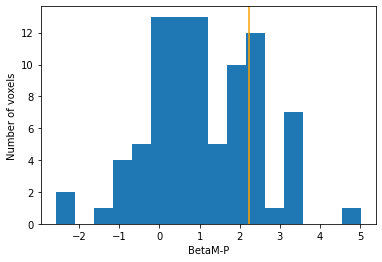

/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2M80_roi.nii.gz: 18 voxels
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2P80_roi.nii.gz: 69 voxels
[69, 18, 84143]
[69, 18, 87]
beta_masked: (128, 128, 21)


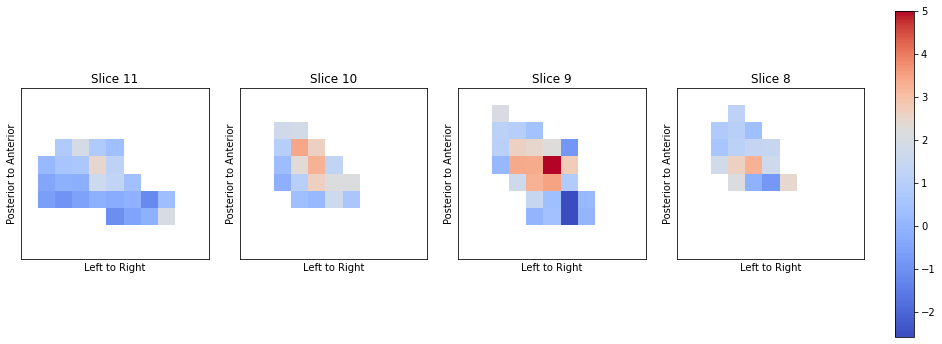

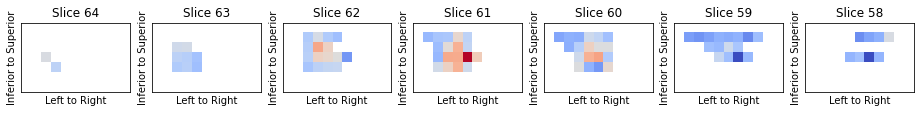

M
(18, 3)
ROI max and min coords [68 62 11] [65 60  8]
ROI extent (total voxel span and max/min distance from center): 
[4 3 4]
[1.111 0.944 1.778]
[-1.889 -1.056 -1.222]
ROI center in EPI and real-world coordinates: 
[66.889 61.056  9.222]
[-18.051   6.521   2.972]
****
P
(69, 3)
ROI max and min coords [70 64 11] [63 58  8]
ROI extent (total voxel span and max/min distance from center): 
[8 7 4]
[2.986 3.551 1.246]
[-4.014 -2.449 -1.754]
ROI center in EPI and real-world coordinates: 
[67.014 60.449  9.754]
[-18.27    5.292   3.665]
****
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-RLGNv2_roi.nii.gz
(67, 3)
ROI max and min coords [45 64 13] [39 59 10]
ROI extent (total voxel span and max/min distance from center): 
[7 6 4]
[2.925 2.896 1.567]
[-3.075 -2.104 -1.433]
ROI center in EPI and real-world coordinates: 
[42.075 61.104 11.433]
[25.374  5.813  6.776]
****
****
****
Given the LGN mask 
/Users/smerdis/data/LGN/BIDS/JS_combined/derivat

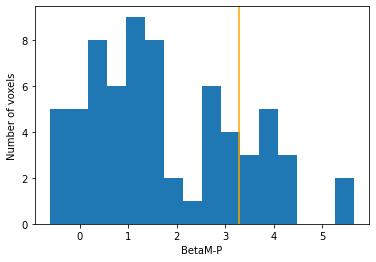

/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-RLGNv2M80_roi.nii.gz: 14 voxels
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-RLGNv2P80_roi.nii.gz: 53 voxels
[53, 14, 84143]
[53, 14, 67]
beta_masked: (128, 128, 21)


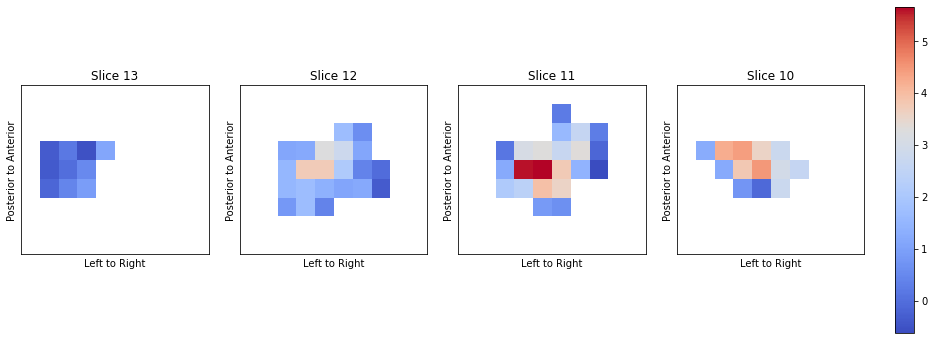

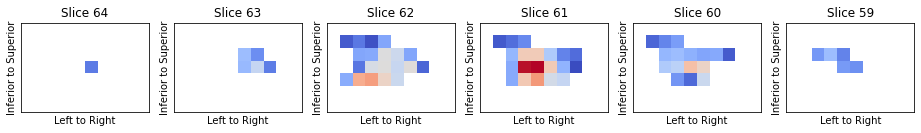

M
(14, 3)
ROI max and min coords [44 62 12] [40 60 10]
ROI extent (total voxel span and max/min distance from center): 
[5 3 3]
[1.857 0.786 1.214]
[-2.143 -1.214 -0.786]
ROI center in EPI and real-world coordinates: 
[42.143 61.214 10.786]
[25.255  6.233  5.707]
****
P
(53, 3)
ROI max and min coords [45 64 13] [39 59 10]
ROI extent (total voxel span and max/min distance from center): 
[7 6 4]
[2.943 2.925 1.396]
[-3.057 -2.075 -1.604]
ROI center in EPI and real-world coordinates: 
[42.057 61.075 11.604]
[25.406  5.703  7.059]
****


In [105]:
for roi in final_big_rois:
    utils.roi_stats({roi:load_img(roi)}, lgn_ref_img)
    if 'desc-L' in roi:
        M_roi, P_roi, threshold = utils.assign_roi_percentile(roi, beta_MP_img, 80, lgn_ref_img, 'L')
    elif 'desc-R' in roi:
        M_roi, P_roi, threshold = utils.assign_roi_percentile(roi, beta_MP_img, 80, lgn_ref_img, 'R')
    else:
        print('Error - not sure which hemisphere roi is in')
    utils.roi_stats({'M':load_img(M_roi), 'P':load_img(P_roi)}, lgn_ref_img)

desc-LLGNv2 ['/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2M80_roi.nii.gz', '/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2P80_roi.nii.gz']
Big roi extends from [-11.245   1.724  -0.215] to [-23.495  10.928   7.071]
Extent is [-12.25    9.205   7.286] and center is [-18.225   5.546   3.522]
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2M80_roi.nii.gz
[-18.051   6.521   2.972]
[0.444 0.479 0.563]
/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-LLGNv2P80_roi.nii.gz
[-18.27    5.292   3.665]
[0.427 0.612 0.467]
desc-RLGNv2 ['/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-RLGNv2M80_roi.nii.gz', '/Users/smerdis/data/LGN/BIDS/JS_combined/derivatives/streams/sub-JS/sub-JS_ses-20210505_desc-RLGNv2P80_roi.nii.gz']
Big roi extends from [30.755  2.72

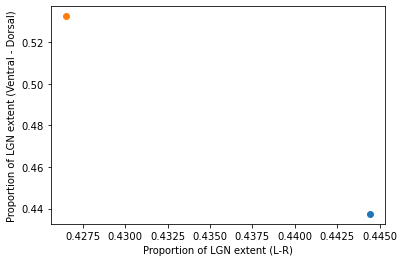

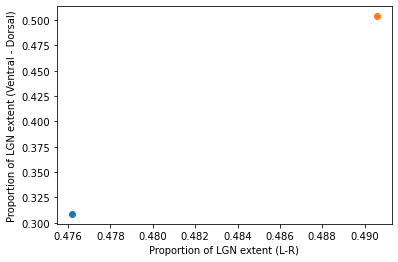

In [96]:
for roi in final_big_rois:
    big_roi_stub = op.basename(roi).split('_')[-2]
    subdivision_rois = [f for f in rois if big_roi_stub in f and ('P' in f or 'M' in f)]
    print(big_roi_stub, subdivision_rois)
    utils.roi_centers(roi, subdivision_rois, load_img(lgn_ref_vol))

### Cross-validation

In [ ]:
# add code to:
# compute threshold statistics (variance etc) across xval runs
# 
def cross_val_glm(sub, ses, task, runs, raw_layout, preproc_layout):
    print(raw_layout, preproc_layout, sep="\n")
    raw_data_dir = raw_layout.root
    out_dir = preproc_layout.root
    working_dirs = []
    for i,r in enumerate(runs):
        other_runs = [*runs[0:i], *runs[i+1:]]
        print(i, r, other_runs)
        wdir = utils.run_fixedeffects_glm(sub, ses, task, other_runs,
                    raw_data_dir, out_dir, working_dir_suffix=f"excrun{r}")
        working_dirs.append(wdir)
    return working_dirs

In [ ]:
# beta_imgs = []
# threshold = 6.0
# for workdir in hemi_xval_outputs:
#     datasink = f"{workdir}/fixedeffects/modelfit/datasink"
#     xval_suffix = op.split(workdir)[-1].split('_')[-1] # e.g. 'excrun1'
#     print("xvalRUN", workdir) #, datasink, sep="\n")
#     #!ls {mp_datasink}
#     l1, l2 = utils.get_model_outputs(datasink, [1])
#     beta = l2[0]
#     beta_img = load_img(beta)
#     print(beta, beta_img.shape)
#     #thresholded_beta = threshold_img(beta_img, threshold, copy=True)
#     bin_beta = math_img(f'img > {threshold}', img=beta_img)
#     bin_beta.to_filename(f"{out_dir}/sub-{sub}_ses-{ses}_hemi_mask_{xval_suffix}_thr{threshold:.0f}.nii.gz")
#     #print(np.count_nonzero(thresholded_beta.get_fdata()), np.count_nonzero(bin_beta.get_fdata()))
#     beta_imgs.append(bin_beta)
# print(beta_imgs)
# intersect_img = nilearn.masking.intersect_masks(beta_imgs, threshold=1)
# intersect_img.to_filename(f"{out_dir}/sub-{sub}-ses-{ses}_hemi_intersect_mask_thr{threshold:.0f}.nii.gz")
# print((np.logical_and(*[b.get_fdata() for b in beta_imgs])).to_filename)

In [ ]:
mp_xval_outputs = cross_val_glm(sub, "20191221", "mp", [1, 2, 3, 4, 5, 6, 7, 8], raw_layout, preproc_layout)

In [ ]:
mp_xval_outputs

In [ ]:
plt.imshow(ref_vol_img.get_data()[:,:,13])

In [ ]:
thresholds = np.empty((2, len(mp_xval_outputs)))
for (i, mp_workdir) in enumerate(mp_xval_outputs):
    mp_datasink = f"{mp_workdir}/fixedeffects/modelfit/datasink"
    print("xvalRUN", mp_workdir, mp_datasink, sep="\n")
    #!ls {mp_datasink}
    _, mp_l2 = utils.get_model_outputs(mp_datasink, [1])
    beta_MP = mp_l2[0]
    beta_MP_img = load_img(beta_MP)
    print("Left:")
    LP_roi, LM_roi, Lthreshold = utils.assign_roi_percentile(rois[0], beta_MP, 20, ref_vol_img, 'L')
    thresholds[0, i] = Lthreshold
    print("Right:")
    RP_roi, RM_roi, Rthreshold = utils.assign_roi_percentile(rois[1], beta_MP, 20, ref_vol_img, 'R')
    thresholds[1, i] = Rthreshold
    print("*********\n")

In [ ]:
np.mean(thresholds, axis=1)

In [ ]:
np.std(thresholds, axis=1)

## Coherence analysis to identify LGN voxels responding at flicker frequency

### Use the actual utils.py function

In [ ]:
hemi_bolds, hemi_masks, hemi_eventfiles, hemi_TR, hemi_confounds = utils.get_files(sub, "20201029", "hemi",
    raw_data_dir, out_dir, run=[1, 2])

### Define hemifield alternation time series etc

In [ ]:
cycle_duration = 27 # (should be 27s)
hemi_freq = (1.0/cycle_duration) # of hemifield alternation, in hertz
n_trs_func = 139 # Length, in TRs, on a functional scan
total_len = n_trs_func*hemi_TR # seconds
Fs = 1/hemi_TR # Sampling freq
trs_exc_beg = 6
trs_exc_end = 1
nfft = 61 #Number of time points to use in the window - 61 gives a band centered at .037037...
#nperseg = n_trs_func - trs_exc_beg - trs_exc_end

# frequency band of physiological relevance
f_lb = 0.02
f_ub = 0.15

# frequency band within which hemifield alternation related activity exists
f_lb_hemi = 0.035
f_ub_hemi = 0.038

print(hemi_freq)

t = np.arange(0.0, total_len, hemi_TR)
t_trim = np.arange((trs_exc_beg-1)*hemi_TR, (total_len - trs_exc_beg - trs_exc_end)+1, hemi_TR)
hemifield_alternation_sinusoid = np.sin(hemi_freq*2*np.pi*t)
hemi_alt_trim = hemifield_alternation_sinusoid[trs_exc_beg:(-1*trs_exc_end)]
print(t, hemifield_alternation_sinusoid.shape)

hemi_ts = ts.TimeSeries(data=hemifield_alternation_sinusoid,
                         sampling_interval=hemi_TR)
hemi_ts_trim = ts.TimeSeries(data=hemi_alt_trim,
                         sampling_interval=hemi_TR)

fig, ax = plt.subplots(1)
ax.set_xlim(0, 50)
ax.plot(t, hemifield_alternation_sinusoid)
#ax.plot(t_trim, hemi_alt_trim)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Hemifield alternation")

In [ ]:
print(final_big_rois)

In [ ]:
roi = hemi_masks[0]

##### Run 1 of hemifield

In [ ]:
_, lgn_ts_run1 = utils.get_timeseries_from_file(hemi_bolds[0], roi, hemi_TR,
                                detrend=True, standardize='psc', high_pass=f_lb, low_pass=f_ub)

In [ ]:
_, (hemi_coh_by_voxel, hemi_phase_by_voxel) = utils.seed_coherence_timeseries(hemi_ts, lgn_ts_run1, f_ub, f_lb, dict(NFFT=nfft))

##### Run 2 of hemifield

##### No detrending or standardization

In [ ]:
lgn_masker, lgn_ts_run2 = utils.get_timeseries_from_file(hemi_bolds[1], roi, hemi_TR,
                                detrend=False, standardize=False, high_pass=f_lb, low_pass=f_ub)
_, (hemi_coh_by_voxel, hemi_phase_by_voxel) = utils.seed_coherence_timeseries(hemi_ts, lgn_ts_run2, f_ub, f_lb, dict(NFFT=nfft))

##### Detrended but no standardization

In [ ]:
lgn_masker, lgn_ts_run2 = utils.get_timeseries_from_file(hemi_bolds[1], roi, hemi_TR,
                                detrend=True, standardize=False, high_pass=f_lb, low_pass=f_ub)
_, (hemi_coh_by_voxel, hemi_phase_by_voxel) = utils.seed_coherence_timeseries(hemi_ts, lgn_ts_run2, f_ub, f_lb, dict(NFFT=nfft))

##### With detrending and conversion to percent signal change

In [ ]:
lgn_masker, lgn_ts_run2 = utils.get_timeseries_from_file(hemi_bolds[1], roi, hemi_TR,
                                detrend=True, standardize='psc', high_pass=f_lb, low_pass=f_ub)
_, (hemi_coh_by_voxel, hemi_phase_by_voxel) = utils.seed_coherence_timeseries(hemi_ts, lgn_ts_run2, f_ub, f_lb, dict(NFFT=nfft))

#### Average the runs for better SNR

In [ ]:
lgn_masker

In [ ]:
mean_bold_timeseries = utils.average_timeseries(hemi_bolds, lgn_masker)

In [ ]:
mean_bold_timeseries.shape

In [ ]:
trim_bold_nm = mean_bold_timeseries[trs_exc_beg:(-1*trs_exc_end),:] # note we are using the mean of the two runs
trim_bold_nm.shape

In [ ]:
mean_ts = ts.TimeSeries(data=trim_bold_nm.T, sampling_interval=hemi_TR)
hemi_analyzer, (hemi_coh_by_voxel, hemi_phase_by_voxel) = utils.seed_coherence_timeseries(hemi_ts_trim, mean_ts, f_ub, f_lb, dict(NFFT=nfft))

##### Run it again but this time with a narrow frequency range for just hemifield alternation

In [ ]:
hemi_analyzer, (hemi_coh_by_voxel, hemi_phase_by_voxel) = utils.seed_coherence_timeseries(hemi_ts_trim, mean_ts,
                                                                   f_ub_hemi, f_lb_hemi, dict(NFFT=nfft))

#### Write coherence values to Nifti file

In [ ]:
lgn_masker

In [ ]:
lgn_masker.get_params()

In [ ]:
len(hemi_coh_by_voxel)

In [ ]:
coherence_img = lgn_masker.inverse_transform(hemi_coh_by_voxel)
coherence_img.shape

In [ ]:
phase_img = lgn_masker.inverse_transform(hemi_phase_by_voxel)
phase_img.shape

In [ ]:
hemi_coh_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_task-hemi_desc-hemialtCoh_map.nii")
hemi_phase_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_task-hemi_desc-hemialtPhase_map.nii")

In [ ]:
coherence_img.to_filename(hemi_coh_fn)
phase_img.to_filename(hemi_phase_fn)

#### Look at cortical ROI coherence with hemifield alternations

In [ ]:
cortical_masker, cortical_ts_run2 = utils.get_timeseries_from_file(hemi_bolds[1], cortical_rois[0], hemi_TR,
                                detrend=False, standardize='zscore', high_pass=f_lb, low_pass=f_ub)
_, (hemi_coh_by_voxel_cortex, hemi_phase_by_voxel_cortex) = utils.seed_coherence_timeseries(hemi_ts, cortical_ts_run2, f_ub_hemi, f_lb_hemi, dict(NFFT=nfft))

#### Write coherence values to Nifti file

In [ ]:
coherence_img = cortical_masker.inverse_transform(hemi_coh_by_voxel_cortex)
coherence_img.shape

In [ ]:
print(cortex_coh_fn)

In [ ]:
coherence_img.to_filename(cortex_coh_fn)

#### SpectralAnalyzer - view and plot FFT, PSD, etc.

In [ ]:
def plot_spectra(S_original, voxid):
    fig01 = plt.figure()
    ax01 = fig01.add_subplot(1, 1, 1)
    if voxid is None:
        ax01.plot(S_original.psd[0],
                  S_original.psd[1],
                  label='PSD')
        ax01.plot(S_original.spectrum_fourier[0],
              np.abs(S_original.spectrum_fourier[1]),
              label='FFT')
#         ax01.plot(S_original.periodogram[0],
#               np.abs(S_original.periodogram[1]),
#               label='Periodogram')

#         ax01.plot(S_original.spectrum_multi_taper[0],
#               np.abs(S_original.spectrum_multi_taper[1]),
#               label='Multitaper')
        
    else:
        ax01.plot(S_original.psd[0],
                  S_original.psd[1][voxid],
                  label='PSD')
        ax01.plot(S_original.spectrum_fourier[0],
              np.abs(S_original.spectrum_fourier[1][voxid]),
              label='FFT')
#         ax01.plot(S_original.spectrum_multi_taper[0],
#               np.abs(S_original.spectrum_multi_taper[1][voxid]),
#               label='Multitaper')
    print(S_original.psd[0], S_original.psd[1], len(S_original.psd[1]), sep='\n')

    ax01.set_xlabel('Frequency (Hz)')
    ax01.set_ylabel('Power')

    ax01.legend()

In [ ]:
roi_mean_timeseries = ts.TimeSeries(np.mean(mean_ts.data, axis=0), sampling_interval=hemi_TR)

In [ ]:
roi_mean_timeseries.data.shape

In [ ]:
plot_spectra(
    nta.SpectralAnalyzer(hemi_ts_trim, method={#'this_method':'welch',
                                                        'NFFT':132,
                                                        'Fs':hemi_ts_trim.sampling_rate})
    , None)
plot_spectra(
    nta.SpectralAnalyzer(roi_mean_timeseries, method={#'this_method':'welch',
                                                        'NFFT':132,
                                                        'Fs':hemi_ts_trim.sampling_rate}), None)

### Mean across voxels of ROI timerseries but with nfft bins

In [ ]:
plot_spectra(
    nta.SpectralAnalyzer(hemi_ts_trim, method={#'this_method':'welch',
                                                        'NFFT':nfft,
                                                        'Fs':hemi_ts_trim.sampling_rate})
    , None)
plot_spectra(
    nta.SpectralAnalyzer(roi_mean_timeseries, method={#'this_method':'welch',
                                                        'NFFT':nfft,
                                                        'Fs':hemi_ts_trim.sampling_rate}), None)

### SeedCoherenceAnalyzer for connectivity

In [ ]:
# Broken due to BIDS change?
# conn_bolds, conn_masks, conn_eventfiles, conn_TR, conn_confounds = utils.get_files(sub, ses, "conn",
#     raw_data_dir, out_dir, run=[1, 5,])

conn_bolds = ['/Users/smerdis/data/LGN/BIDS/NB_2020/derivatives/streams/sub-NB/ses-20201029/func/sub-NB_ses-20201029_task-conn_run-01_desc-preproc_bold.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_2020/derivatives/streams/sub-NB/ses-20201029/func/sub-NB_ses-20201029_task-conn_run-05_desc-preproc_bold.nii.gz']
conn_masks = ['/Users/smerdis/data/LGN/BIDS/NB_2020/derivatives/streams/sub-NB/sub-NB_ses-20201029_task-conn_mask.nii.gz', '/Users/smerdis/data/LGN/BIDS/NB_2020/derivatives/streams/sub-NB/sub-NB_ses-20201029_task-conn_mask.nii.gz']
conn_TR = 2.25

In [ ]:
f_lb = 0.025
f_ub = 0.15

In [ ]:
print(rois)

In [ ]:
cortical_rois
cortical_roi = cortical_rois[0]

In [ ]:
left_lgn_rois = ['/Users/smerdis/data/LGN/BIDS/NB_2020/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallM80_roi.nii.gz',
                 '/Users/smerdis/data/LGN/BIDS/NB_2020/derivatives/streams/sub-NB/sub-NB_ses-20191221_desc-LLGNsmallP80_roi.nii.gz']

In [ ]:
for roi in left_lgn_rois:
    #if 'M' in roi or 'P' in roi:
    bn = op.basename(roi)
    parts = bn.split('_')
    print(parts)
    cohs = []
    phases = []
    for i, bold in enumerate(conn_bolds):
        print(i, bold)
        bbn = op.basename(bold)
        runpart = [p for p in bbn.split('_') if 'run-' in p][0]
        conn_coh_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_task-conn_{runpart}_{parts[-2]}_coherence_map.nii")
        conn_phase_fn = os.path.join(out_dir, f"sub-{sub}_ses-{ses}_task-conn_{runpart}_{parts[-2]}_phase_map.nii")
        print(conn_coh_fn, conn_phase_fn, sep='\n')
        #below: wholebrain mask with mean of seed roi
        # 2/3/21: cahnged to use cortical roi instead of wholebrain
        a, target_masker, coherence_by_voxel, phase_by_voxel = utils.seed_coherence_analysis(bold, cortical_roi, roi,
                          conn_TR, f_ub, f_lb, mean_seed=True, method=dict(NFFT=64))
        coherence_map_img = target_masker.inverse_transform(coherence_by_voxel)
        phase_img = target_masker.inverse_transform(phase_by_voxel)
        coherence_map_img.to_filename(conn_coh_fn)
        phase_img.to_filename(conn_phase_fn)
        # below: roi with the mean of that roi
        #a = utils.seed_coherence_analysis(bold, roi, roi,
        #      conn_TR, f_ub, f_lb, conn_coh_fn, mean_seed=True)
        # below: cortical roi (hand-defined and hardcoded) with mean of seed ROI
#         a, _ = utils.seed_coherence_analysis(bold, cortical_rois[0], roi,
#               conn_TR, f_ub, f_lb, conn_coh_fn, mean_seed=True)

        cohs.append(a.coherence)
        phases.append(a.relative_phases)    

In [ ]:
img1 = '/Users/smerdis/data/LGN/BIDS/NB_2020/derivatives/streams/sub-NB/sub-NB_ses-20201029_task-conn_run-01_desc-LLGNsmallM80_phase_map.nii'
img2 = '/Users/smerdis/data/LGN/BIDS/NB_2020/derivatives/streams/sub-NB/sub-NB_ses-20201029_task-conn_run-05_desc-LLGNsmallM80_phase_map.nii'


In [ ]:
phase_diff_img = math_img(f"img1 - img2", img1=img1, img2=img2)
phase_diff_path = f"{out_dir}/sub-NB_ses-20201029_task-conn_desc-LLGNsmallM80_leftM_phasediff_map.nii"
phase_diff_img.to_filename(phase_diff_path)

In [ ]:
print(f"fsleyes {conn_ref_vol_path} {phase_diff_path}")

In [ ]:
cohs[0].shape